In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from multiprocessing import Pool
import warnings
#warnings.filterwarnings('ignore')

#### Load up experiment data

In [3]:
# Drug names used in all experiments
drugs = ["DAU", "IDA", "Mito", "VP16", "6TG", "2CdA", "FLD", "AraC", "AZC", "DAC", "6MP", "MTX", "AG221", "ABT199","ATRA"]
drugs.sort()
# Local path for the project folder
PROJECT_PATH = Path("/home/wak/toprak-lab/aml_drug_synergy")
# Raw data is located here as a single tab-separated values file
data_path = PROJECT_PATH / "data/raw_curated_single_file/ETECS02-ETECS03-combined-normalized.tsv"
# Parse data into a Pandas dataframe object
raw = pd.read_csv(data_path, sep='\t', dtype={'Conc. A [uM]':float, 'Conc. B [uM]':float, 'Masked':object})
raw

,Index,Plate,Plate ID,Row,Column,Compound A,Conc. A [uM],Compound B,Conc. B [uM],Well Type,Masked,Well Tags,Timestamp,Raw,Normalized,Normalized2,Plate Mask,Cell Line,Cell Line+Well Type
0,1,1,ETECS02 FKH1_1,A,1,ATRA,50.000,ATRA,50.0,Compound,NaN,NaN,13.03.2020 01:48:00,963720.0,-25.443290,0.739827,NaN,FKH1,FKH1 Compound
1,2,1,ETECS02 FKH1_1,A,2,ATRA,5.000,ATRA,50.0,Compound,NaN,NaN,13.03.2020 01:48:00,1300880.0,0.640569,1.006550,NaN,FKH1,FKH1 Compound
2,3,1,ETECS02 FKH1_1,A,3,ATRA,0.500,ATRA,50.0,Compound,NaN,NaN,13.03.2020 01:48:00,1262280.0,-2.345660,0.976014,NaN,FKH1,FKH1 Compound
3,4,1,ETECS02 FKH1_1,A,4,ATRA,0.050,ATRA,50.0,Compound,NaN,NaN,13.03.2020 01:48:00,1277200.0,-1.191397,0.987817,NaN,FKH1,FKH1 Compound
4,5,1,ETECS02 FKH1_1,A,5,ATRA,0.005,ATRA,50.0,Compound,NaN,NaN,13.03.2020 01:48:00,1295760.0,0.244469,1.002500,NaN,FKH1,FKH1 Compound
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123573,9212,24,ETECS03 Kasumi1_24,P,20,NaN,NaN,NaN,NaN,Compound,NaN,NaN,26.04.2021 11:32:29,2774720.0,47.481660,1.483074,NaN,Kasumi1,Kasumi1 Compound
123574,9213,24,ETECS03 Kasumi1_24,P,21,NaN,NaN,NaN,NaN,Compound,NaN,NaN,26.04.2021 11:32:29,2819560.0,49.864990,1.507322,NaN,Kasumi1,Kasumi1 Compound
123575,9214,24,ETECS03 Kasumi1_24,P,22,NaN,NaN,NaN,NaN,Compound,NaN,NaN,26.04.2021 11:32:29,2641640.0,40.408210,1.411109,NaN,Kasumi1,Kasumi1 Compound
123576,9215,24,ETECS03 Kasumi1_24,P,23,NaN,NaN,NaN,NaN,Compound,NaN,NaN,26.04.2021 11:32:29,3013280.0,60.161580,1.612078,NaN,Kasumi1,Kasumi1 Compound


Raw effect matrices imported here is summarized and organized in `src/31_import_raw_data.ipynb`. 8x8 drug pair measurements are coming from the experiment ETECS02, and 11x11 measurements are coming from ETECS03.

In [4]:
with open(PROJECT_PATH / 'data/raw_effect_matrices/raw_effect_matrices_8x8.pkl', 'rb') as f:
    raw_effect_8 = pickle.load(f)
with open(PROJECT_PATH / 'data/raw_effect_matrices/raw_effect_matrices_11x11.pkl', 'rb') as f:
    raw_effect_11 = pickle.load(f)

In [5]:
# Print total number of measured drug pairs in each experiment
print('8x8 screen')
for cell_line in raw_effect_8.keys():
    print(cell_line, len(raw_effect_8[cell_line]))
print('11x11 screen')
for cell_line in raw_effect_11.keys():
    print(cell_line, len(raw_effect_11[cell_line]))

8x8 screen
FKH1 120
HL60 120
K562 120
TF1 120
IDH2 105
Kasumi1 120
11x11 screen
FKH1 21
HL60 26
K562 43
TF1 0
IDH2 36
Kasumi1 24


In [6]:
# Browse a single drug-pair measurement
raw_effect_8['Kasumi1'][('ATRA','AZC')]

Conc. B [uM],0.0000,1.7558,2.6337,3.9506,5.9259,8.8889,13.3333,20.0000
Conc. A [uM],,,,,,,,
0.0000,0.963983,0.699182,0.646268,0.545612,0.510560,0.392870,0.323276,0.306607
0.7810,0.902360,0.557732,0.533287,0.457055,0.399191,0.310845,0.258828,0.237150
1.5625,0.911343,0.608996,0.519696,0.443043,0.357138,0.291840,0.261142,0.241842
3.1250,0.841712,0.564085,0.492387,0.436237,0.345329,0.292958,0.244536,0.220939
6.2500,0.881467,0.534040,0.498070,0.421328,0.337484,0.277965,0.234693,0.205308
12.5000,0.907183,0.522622,0.501044,0.419288,0.325048,0.283131,0.233444,0.226896
25.0000,0.757425,0.485929,0.474257,0.412925,0.326603,0.257125,0.206246,0.211676
50.0000,0.642246,0.495023,0.414801,0.383502,0.316270,0.279272,0.223828,0.196045


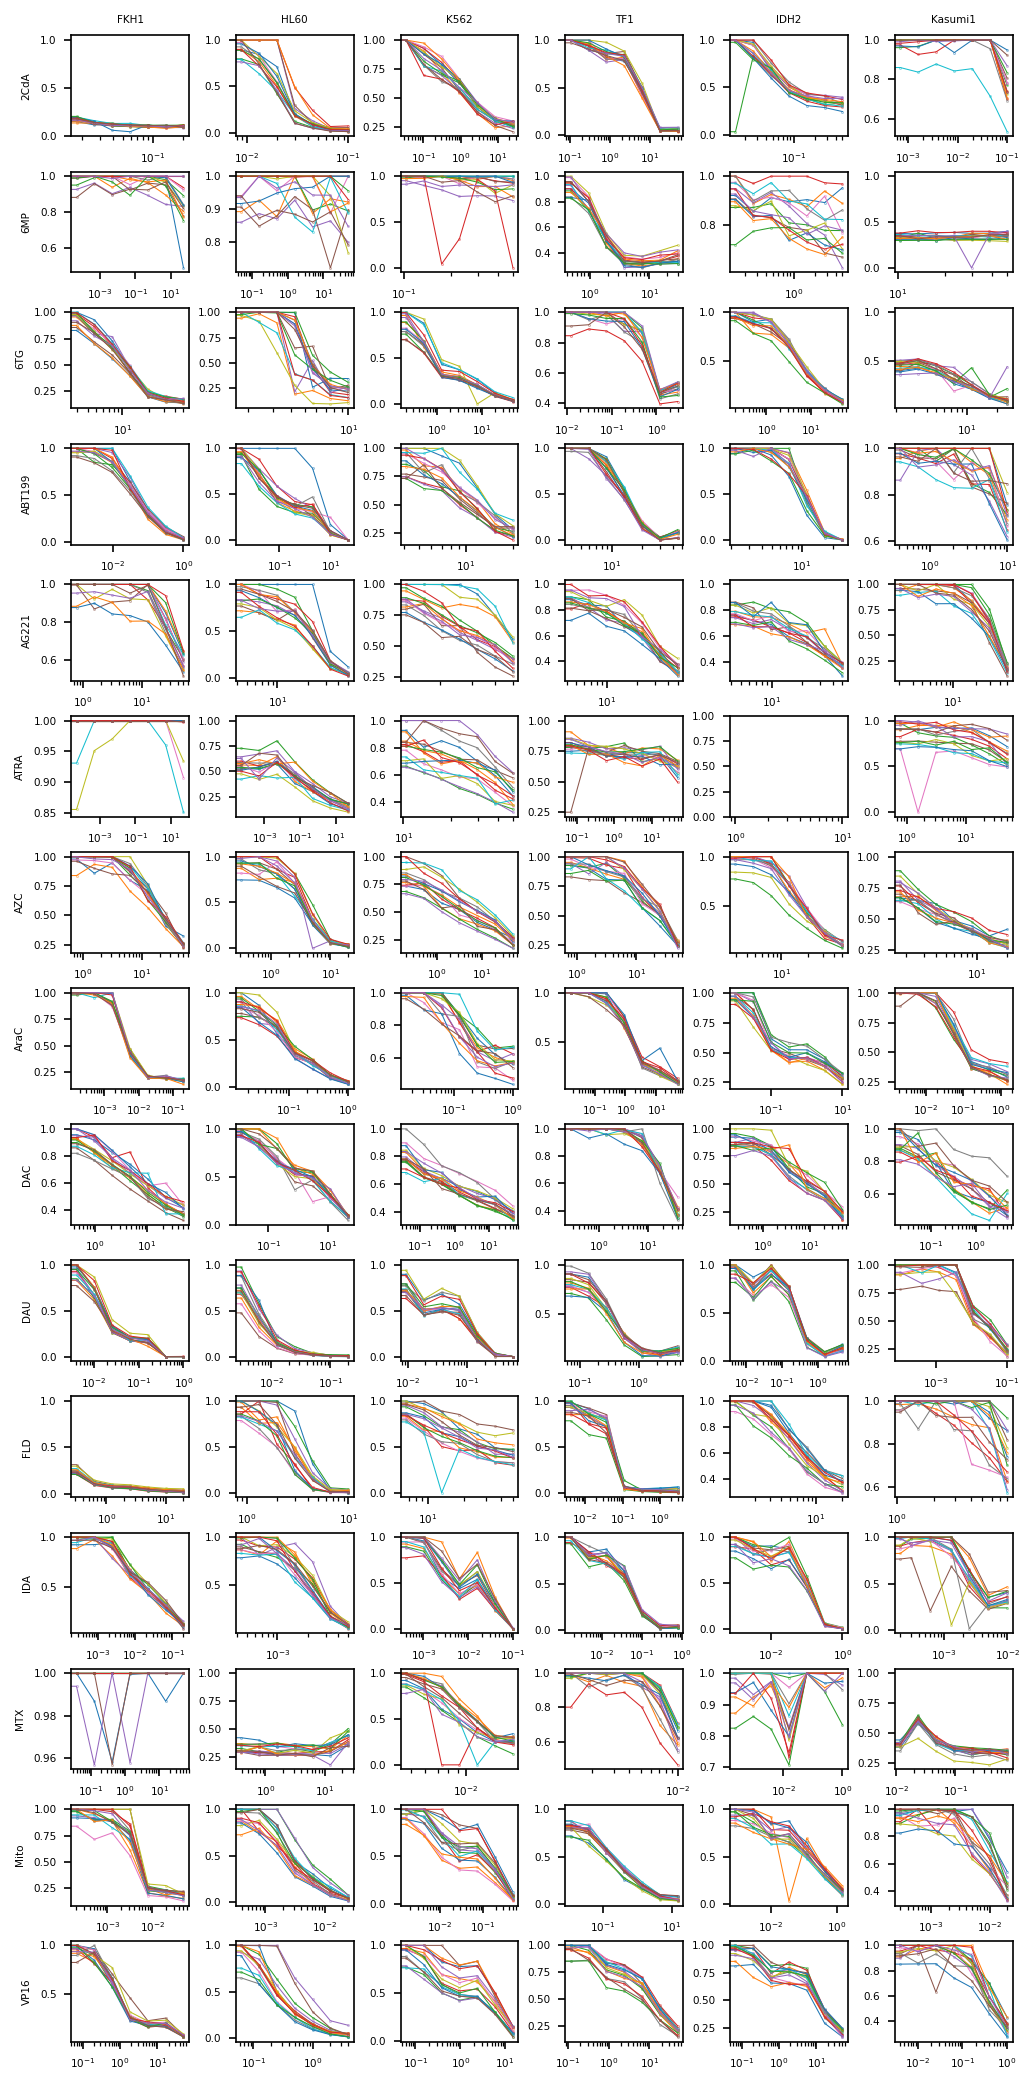

In [7]:
pal = sns.color_palette('tab10')
fig, axes = plt.subplots(15,6, figsize=(7,14), dpi=150)
fontsize = 5
plt.style.use('default')
for axi, cell_line in enumerate(raw_effect_8.keys()):
    for drug_pair in raw_effect_8[cell_line]:
        druga_effect = raw_effect_8[cell_line][drug_pair].iloc[:,0]
        druga_conc = np.array(list(raw_effect_8[cell_line][drug_pair].index))
        drugb_effect = raw_effect_8[cell_line][drug_pair].iloc[0,:]
        drugb_conc = np.array(list(raw_effect_8[cell_line][drug_pair].columns))
        for effect, conc, drugi in [(druga_effect, druga_conc, np.searchsorted(drugs,drug_pair[0])),
                                    (drugb_effect, drugb_conc, np.searchsorted(drugs,drug_pair[1]))]:
            ax = axes[drugi, axi]
            with pal:
                ax.plot(conc, effect, alpha=1, linestyle='-', marker='o', linewidth=0.5, markersize=0.2)

for drugi, drug in enumerate(drugs):
    for axi, cell_line in enumerate(raw_effect_8.keys()):
        ax = axes[drugi, axi]
        ax.set_xscale('log')
#         ax.set_xlabel('')
        ax.tick_params(axis='both', which='major', labelsize=fontsize)
        ax.xaxis.set_major_locator(mpl.ticker.LogLocator(base=10))
        ax.xaxis.set_minor_locator(mpl.ticker.LogLocator(base=10, subs='all'))
        ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())
#         # if axi!=0:
#         #     ax.set_yticklabels([])
#         # if drugi!=len(drugs)-1:
#         #     ax.set_xticklabels([])
        if axi==0:
            ax.set_ylabel(drugs[drugi],fontsize=fontsize)
        if drugi==0:
            ax.set_title(cell_line, fontsize=fontsize)
fig.tight_layout()
fig.subplots_adjust(wspace=0.4, hspace=0.35)
fig.savefig(PROJECT_PATH / f'dump/plots/single_drc_vs_cell_line_8x8.png', dpi=600, bbox_inches="tight")

### Sigmoid Estimation of the Drug Response Curves

#### Curve fitting functions

In [8]:
from scipy.optimize import curve_fit

def sigmoid(x, bpos, bshape):#, b):
    y = 1 / (1 + np.exp(-bshape*(x-bpos)))# + b
    return (y)

def sig_eval(x, bpos, bshape, x_log_base=2):
    """This func evalutes a sigmoid fit done in log in x-axis
    also adjusts first data point from 0 to x[1]/x_log_base.
    """
    xa = np.array(list(x)).copy()
    if xa[0]<1e-7:
        xa[0] = xa[1]/x_log_base
    xa = np.emath.logn(x_log_base, xa)
    return sigmoid(xa, bpos, bshape), xa

def sig_fit(effect, drug_conc, x_log_base=2):
    """This functions assumes drug concentration starts from zero 
    and monotonically increasing."""
    xdata = np.array(list(drug_conc)).copy()
    xdata[0] = xdata[1]/x_log_base
    #horizon0 = [xdata[0]/(x_log_base**i) for i in [2,1]]
    #xdata = np.concatenate((horizon0, xdata))
    xdata[xdata<1e-6] = xdata[0]
    xdata = np.emath.logn(x_log_base, xdata)
    ydata = effect.copy()
    # fit according to relative viability
    ydata = ydata / ydata[0]
    ydata[ydata>1] = 1
    #ydata = np.concatenate(([ydata[0]]*2, ydata))
    # eliminate nans
    nans = (np.isnan(xdata) | np.isnan(ydata))
    xdata = xdata[~nans]
    ydata = ydata[~nans]
    if len(xdata)<len(effect)-2:
        #print('Fit input has too many NaN values.')
        return None, None, None
    # initial parameter estimates
    p0 = [np.median(xdata), -.5]#, min(ydata)]
    try:
        p, pcov = curve_fit(sigmoid, xdata, ydata, p0, bounds=([-np.inf,-np.inf],[np.inf,np.inf]), method='lm', maxfev=10000)
    except BaseException:
        #print('Sigmoid fit did not converge.')
        return None, None, None
    #print(p)
    return p, xdata, ydata

#### Single drug sigmoid fits

/home/wak/micromamba/envs/aml_drug_synergy/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/wak/micromamba/envs/aml_drug_synergy/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/wak/micromamba/envs/aml_drug_synergy/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/wak/micromamba/envs/aml_drug_synergy/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/wa

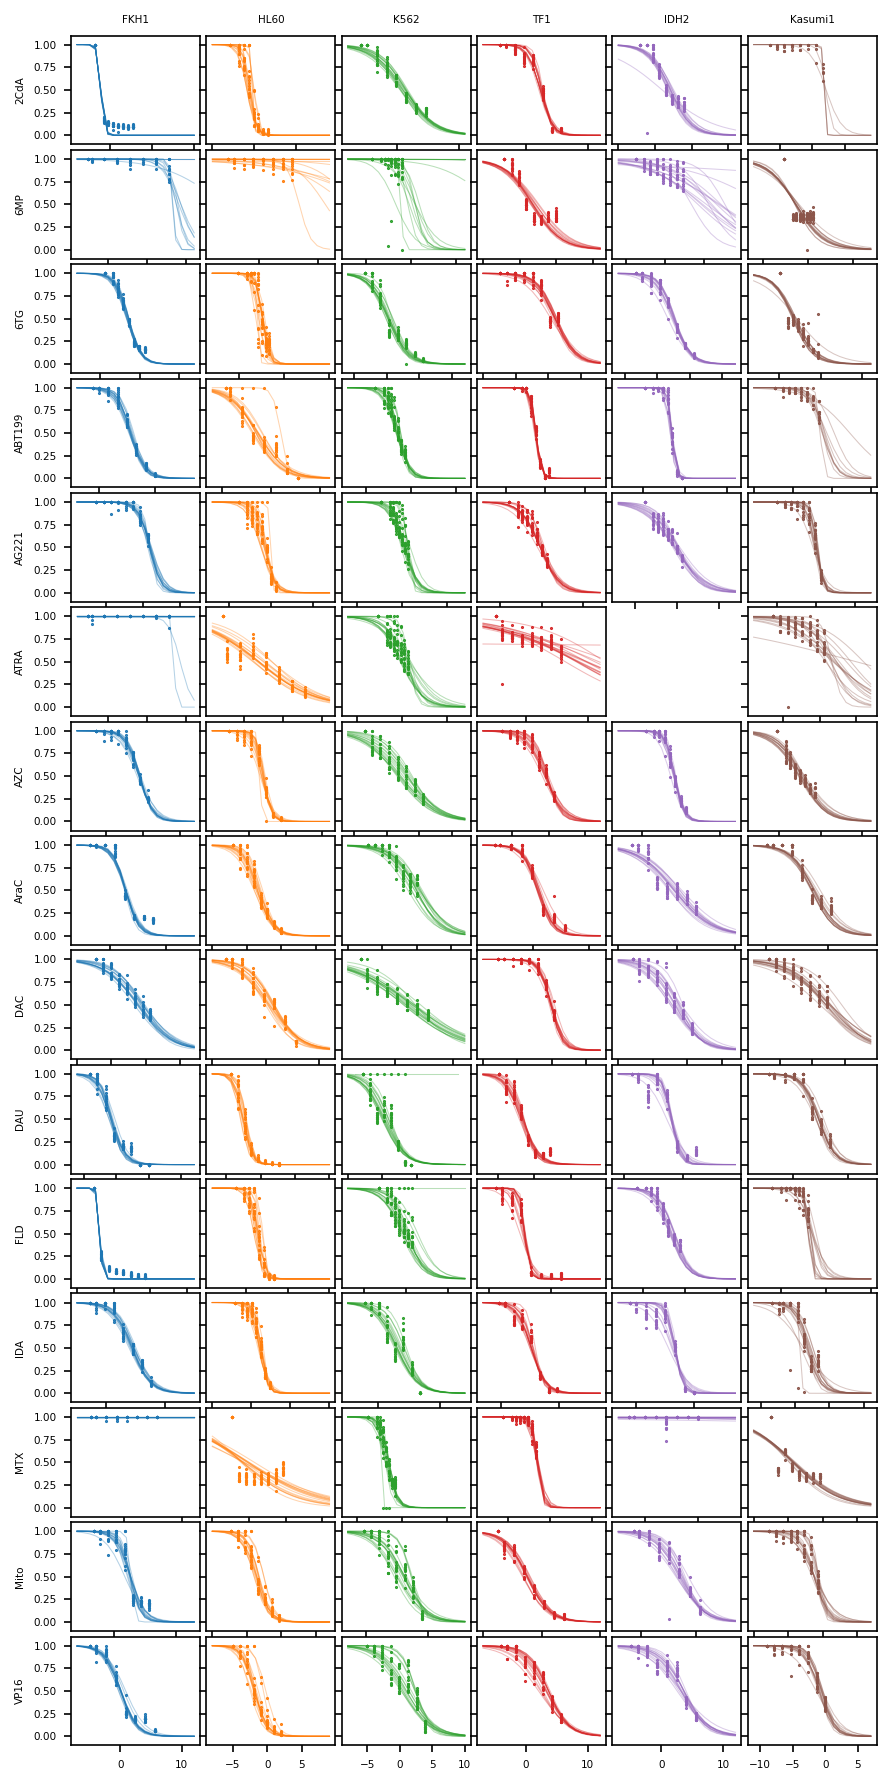

In [9]:
pal = sns.color_palette('tab10')
fig, axes = plt.subplots(15,6, figsize=(6,12), dpi=150)
plt.style.use('default')
single_drc_models = {}
sig_effect_8 = {}

for axi, cell_line in enumerate(raw_effect_8.keys()):
    # create bliss estimated effect matrices
    sig_effect_8[cell_line] = {}
    for drug_pair in raw_effect_8[cell_line]:
        # start from the raw effect matrix
        sig_effect_8[cell_line][drug_pair] = []
        # collect single drug response at each drug pair
        druga_effect = raw_effect_8[cell_line][drug_pair].iloc[:,0]
        druga_conc = np.array(list(raw_effect_8[cell_line][drug_pair].index))
        drugb_effect = raw_effect_8[cell_line][drug_pair].iloc[0,:]
        drugb_conc = np.array(list(raw_effect_8[cell_line][drug_pair].columns))
        # single drc sigmoid estimations
        for effect, conc, drugi in [(druga_effect, druga_conc, np.searchsorted(drugs,drug_pair[0])),
                                    (drugb_effect, drugb_conc, np.searchsorted(drugs,drug_pair[1]))]:
            ax = axes[drugi, axi]
            p, x, y = sig_fit(effect, conc)
            # record sigmoid fit params here
            sig_effect_8[cell_line][drug_pair].append(p)
            # if fit successful plot results
            if p is not None:
                x_fit = np.logspace(int(x[0])-3, int(x[-1])+7, 20, base=2)
                y_fit, x_fit = sig_eval(x_fit, *p)
                ax.plot(x, y,'o', color=pal[axi], markersize=0.5)
                ax.plot(x_fit, y_fit, color=pal[axi], linewidth=0.5, alpha=0.33)
                ax.set_ylim([-0.1,1.1])
                ax.tick_params(labelsize=fontsize)
            if axi!=0:
                ax.set_yticklabels([])
            if drugi!=14:
                ax.set_xticklabels([])
            if drugi==0:
                ax.set_title(cell_line,fontsize=fontsize)
            if axi==0:
                ax.set_ylabel(drugs[drugi],fontsize=fontsize)
axes[5,4].set_axis_off()
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.savefig(PROJECT_PATH / f'dump/plots/single_drc_vs_cell_line_8x8.png', dpi=600, bbox_inches="tight")

In [10]:
# manually remove cell line drug pairs where single drug response curve measurement was not successful

manual_filter = {
    'FKH1': ['2CdA', '6MP', 'ATRA', 'MTX'],
    'HL60': ['6MP', 'MTX'],
    'K562': ['6MP'],
    'TF1': ['ATRA'],
    'IDH2': ['6MP', 'ATRA', 'MTX'],
    'Kasumi1': ['2CdA', '6MP', '6TG']
}

/home/wak/micromamba/envs/aml_drug_synergy/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/wak/micromamba/envs/aml_drug_synergy/lib/python3.12/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


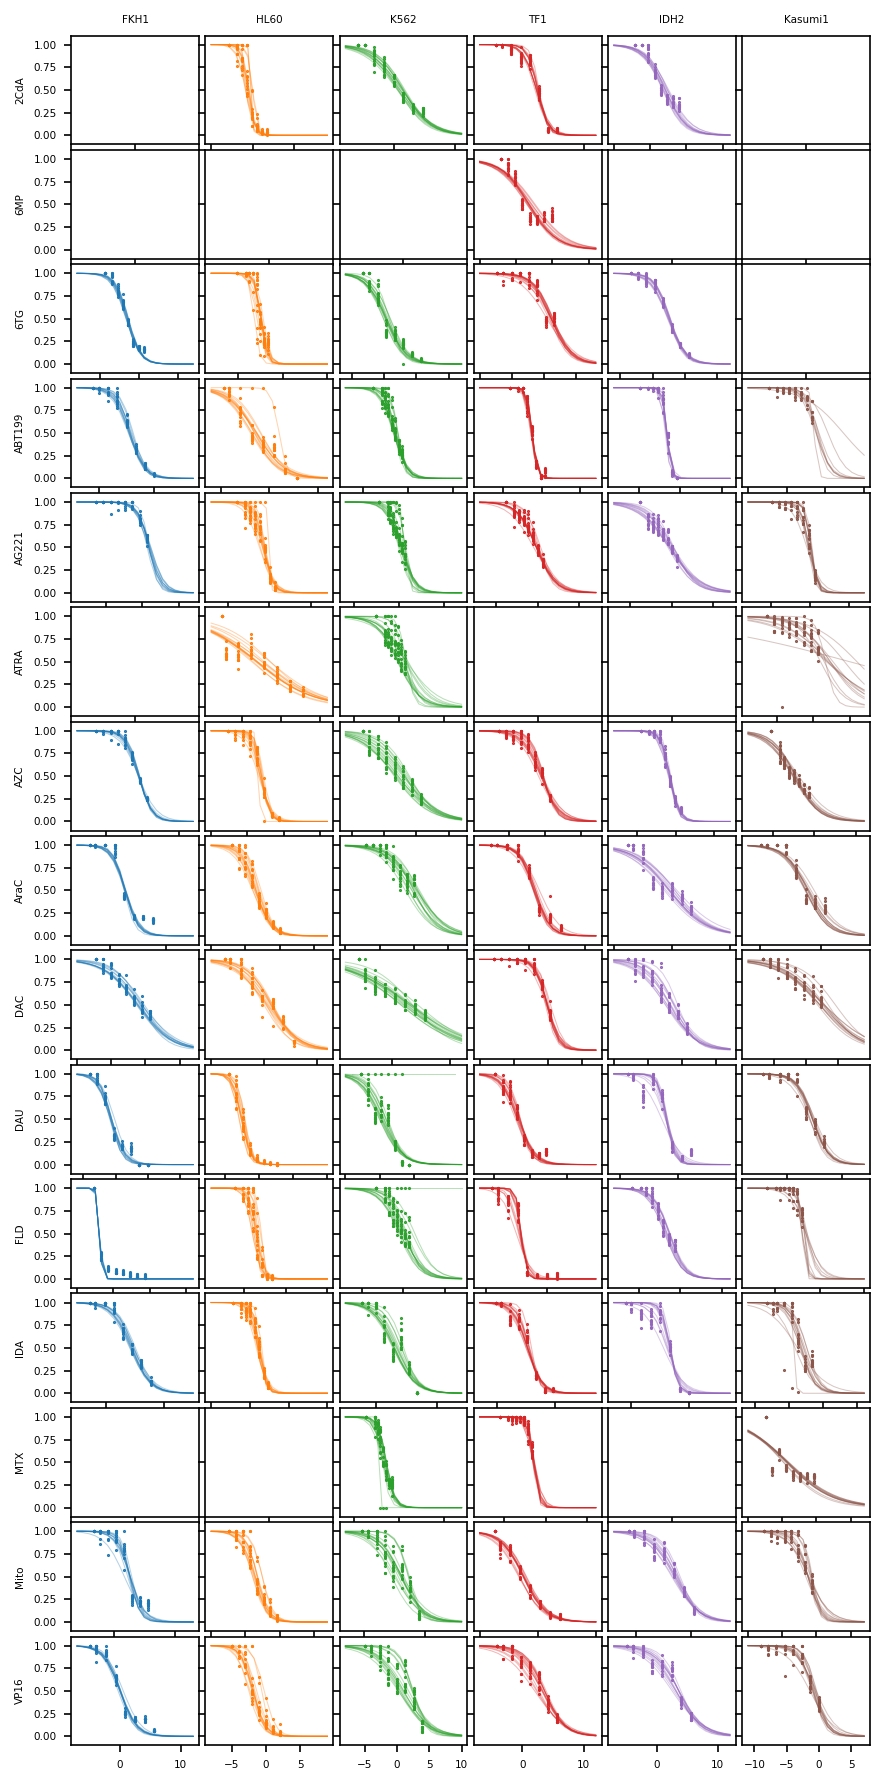

In [11]:
pal = sns.color_palette('tab10')
fig, axes = plt.subplots(15,6, figsize=(6,12), dpi=150)
plt.style.use('default')
single_drc_models = {}
sig_effect_8 = {}

for axi, cell_line in enumerate(raw_effect_8.keys()):
    # create bliss estimated effect matrices
    sig_effect_8[cell_line] = {}
    for drug_pair in raw_effect_8[cell_line]:
        if not ((drug_pair[0] in manual_filter[cell_line]) or (drug_pair[1] in manual_filter[cell_line])):
            # start from the raw effect matrix
            sig_effect_8[cell_line][drug_pair] = []
            # collect single drug response at each drug pair
            druga_effect = raw_effect_8[cell_line][drug_pair].iloc[:,0]
            druga_conc = np.array(list(raw_effect_8[cell_line][drug_pair].index))
            drugb_effect = raw_effect_8[cell_line][drug_pair].iloc[0,:]
            drugb_conc = np.array(list(raw_effect_8[cell_line][drug_pair].columns))
            # single drc sigmoid estimations
            for effect, conc, drugi in [(druga_effect, druga_conc, np.searchsorted(drugs,drug_pair[0])),
                                        (drugb_effect, drugb_conc, np.searchsorted(drugs,drug_pair[1]))]:
                ax = axes[drugi, axi]
                p, x, y = sig_fit(effect, conc)
                # record sigmoid fit params here
                sig_effect_8[cell_line][drug_pair].append(p)
                # if fit successful plot results
                if p is not None:
                    x_fit = np.logspace(int(x[0])-3, int(x[-1])+7, 20, base=2)
                    y_fit, x_fit = sig_eval(x_fit, *p)
                    ax.plot(x, y,'o', color=pal[axi], markersize=0.5)
                    ax.plot(x_fit, y_fit, color=pal[axi], linewidth=0.5, alpha=0.33)
                    ax.set_ylim([-0.1,1.1])
                    ax.tick_params(labelsize=fontsize)
                if axi!=0:
                    ax.set_yticklabels([])
                if drugi!=14:
                    ax.set_xticklabels([])
                if drugi==0:
                    ax.set_title(cell_line,fontsize=fontsize)
                if axi==0:
                    ax.set_ylabel(drugs[drugi],fontsize=fontsize)
# turn off empty ones
for axi, ax in enumerate(axes.flat):
    if len(ax.get_lines())==0:
        drugi = axi//len(raw_effect_8.keys())
        if axi < len(raw_effect_8.keys()):
            ax.set_title(list(raw_effect_8.keys())[axi], fontsize=fontsize)
        if axi%len(raw_effect_8.keys())==0:
            ax.set_ylabel(drugs[drugi], fontsize=fontsize)
            ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
            ax.set_yticklabels(['0.00', '0.25', '0.50', '0.75', '1.00'],fontsize=fontsize)
            ax.set_ylim([-0.1,1.1])
        else:
            ax.set_yticklabels([])
        ax.set_xticklabels([])
# for ax in axes.flat:
#     axes[5,4].set_axis_off()
plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.05)
fig.savefig(PROJECT_PATH / f'dump/plots/single_drc_vs_cell_line_8x8_filtered.png', dpi=600, bbox_inches="tight")

In [12]:
for ax in axes.flat:
    if len(ax.get_lines())==0:
        ax.set_axis_off()

In [34]:
single_drc_long = []
for axi, cell_line in enumerate(raw_effect_8.keys()):
    for drug_pair in sig_effect_8[cell_line]:
        if  sig_effect_8[cell_line][drug_pair][0] is not None:
            single_drc_long.append({'cell_line': cell_line, 'drug': drug_pair[0],
                                    'bpos': sig_effect_8[cell_line][drug_pair][0][0],
                                    'bshape': sig_effect_8[cell_line][drug_pair][0][1]})
        if  sig_effect_8[cell_line][drug_pair][1] is not None:
            single_drc_long.append({'cell_line': cell_line, 'drug': drug_pair[1],
                                    'bpos': sig_effect_8[cell_line][drug_pair][1][0],
                                    'bshape': sig_effect_8[cell_line][drug_pair][1][1]})
df = pd.DataFrame(single_drc_long)
# export mean IC50 per single drug per cell line
mean_ic50_single_drc = df.groupby(['cell_line','drug'])['bpos'].agg(lambda x: 2**np.mean(x)).to_frame(name='bpos').reset_index().pivot(index='cell_line', columns='drug').T.droplevel(0)
mean_ic50_single_drc_sem = df.groupby(['cell_line','drug'])['bpos'].agg(lambda x: (np.std(x)/np.sqrt(len(x)))).to_frame(name='bpos').reset_index().pivot(index='cell_line', columns='drug').T.droplevel(0)
mean_ic50_single_drc.to_csv(PROJECT_PATH / 'figures/Supplementary Table 1. Single DRC IC50.csv')
mean_ic50_single_drc_sem.to_csv(PROJECT_PATH / 'figures/Supplementary Table 1. Single DRC IC50 SEM.csv')
mean_ic50_single_drc

cell_line,FKH1,HL60,IDH2,K562,Kasumi1,TF1
drug,,,,,,
2CdA,NaN,0.022500,0.135344,2.178914,NaN,5.362250
6MP,NaN,NaN,NaN,NaN,NaN,3.764341
6TG,11.273215,5.622573,5.971380,1.319492,NaN,2.126599
ABT199,0.048581,0.178673,10.532715,12.092850,21.514755,13.433915
AG221,62.005290,19.906144,29.564096,41.030819,31.504092,30.287474
ATRA,NaN,0.021353,NaN,43.481284,205.073307,NaN
AZC,22.886475,3.587116,18.402640,6.556253,6.251903,23.932363
AraC,0.006404,0.096164,0.864743,1.024660,0.217729,2.024953
DAC,18.054475,1.961385,10.117632,6.844064,6.356265,30.331161


In [35]:
mean_ic50_single_drc_sem

cell_line,FKH1,HL60,IDH2,K562,Kasumi1,TF1
drug,,,,,,
2CdA,NaN,0.074334,0.071326,0.100891,NaN,0.044420
6MP,NaN,NaN,NaN,NaN,NaN,0.082307
6TG,0.031168,0.063555,0.037349,0.081771,NaN,0.062538
ABT199,0.072152,0.369619,0.020935,0.045277,0.376316,0.018810
AG221,0.040686,0.069259,0.062601,0.058762,0.051069,0.048128
ATRA,NaN,0.377183,NaN,0.103209,0.397116,NaN
AZC,0.019826,0.052564,0.023473,0.192620,0.059153,0.047009
AraC,0.027109,0.091278,0.163417,0.147143,0.112868,0.074160
DAC,0.099781,0.137906,0.150485,0.205586,0.190589,0.042624


In [158]:
mean_shape_coef = df.groupby(['cell_line','drug'])['bshape'].agg(np.mean).to_frame(name='bshape').reset_index().pivot(index='cell_line', columns='drug').T
mean_shape_coef.to_csv(PROJECT_PATH / 'figures/Supplementary Table 1B. Single DRC bshape.csv')
mean_shape_coef
#df.groupby(['cell_line','drug'])['bshape'].agg(np.mean)

cell_line          FKH1      HL60      IDH2      K562   Kasumi1       TF1
       drug                                                              
bshape 2CdA         NaN -3.449207 -0.684444 -0.415853       NaN -1.121691
       6MP          NaN       NaN       NaN       NaN       NaN -0.492704
       6TG    -1.185806 -2.737932 -0.816200 -0.704353       NaN -0.642585
       ABT199 -0.769035 -0.429244 -3.984247 -1.711909 -1.421957 -2.868041
       AG221  -1.241655 -2.226564 -0.631872 -1.848244 -2.178869 -0.900897
       ATRA         NaN -0.141146       NaN -1.027438 -0.473929       NaN
       AZC    -1.088293 -2.028562 -1.698738 -0.396520 -0.644593 -0.899453
       AraC   -0.844222 -0.921541 -0.313491 -0.530948 -0.527358 -0.715948
       DAC    -0.434187 -0.385633 -0.543237 -0.210778 -0.340022 -1.169017
       DAU    -1.008587 -1.633896 -1.202975 -0.687779 -0.676612 -0.982055
       FLD    -5.479434 -2.866853 -1.029461 -0.837681 -3.270744 -1.952157
       IDA    -0.618295 -2.073900 -1.215093 -0.621514 -1.349963 -0.898898
       MTX          NaN       NaN       NaN -5.495014 -0.298822 -2.785706
       Mito   -1.013583 -1.142166 -0.493432 -0.631035 -1.117835 -0.516761
       VP16   -0.751343 -1.194824 -0.507237 -0.614453 -0.913145 -0.541612

#### Compare observed combination effects vs. Bliss estimations

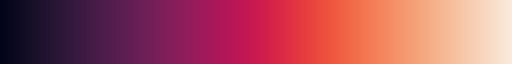

In [47]:
sns.color_palette('rocket',as_cmap=True)

In [36]:
cmap

[(0.2509335357076959, 0.4944143311197457, 0.6104170295454565),
 (0.38609198643351966, 0.5830312563225233, 0.6772342131340513),
 (0.5266567751883763, 0.6751928585334119, 0.7467240840661897),
 (0.6645078356747536, 0.7655751990429636, 0.8148723912340885),
 (0.8050726244296104, 0.8577368012538521, 0.884362262166227),
 (0.9500463204266012, 0.9458771880685795, 0.945349903258932),
 (0.9140860646530862, 0.8246826885128927, 0.8028133239419792),
 (0.875881479522241, 0.7004289759275987, 0.6564695915881414),
 (0.8384144678873866, 0.5785740917778832, 0.5129511551488873),
 (0.8002098827565414, 0.45432037919258916, 0.3666074227950496),
 (0.7634747047461135, 0.3348456555528834, 0.225892295531744)]

In [49]:
cmap = sns.diverging_palette(230, 20, n=11)
def pick_color(value, vmin, vmax, cmap):
    if value > vmax:
        index = vmax
    elif value < vmin:
        index = vmin
    else:
        index = value
    color = cmap[int(np.round((len(cmap)-1)*(index-vmin)/(vmax-vmin)))]
    return color
pick_color(-3, -5, 5, cmap)

(0.5266567751883763, 0.6751928585334119, 0.7467240840661897)

In [50]:
pal = sns.color_palette('tab10')
pal2 = sns.color_palette('tab20')
plt.rc('axes', titlesize=4)
plt.rc('xtick', labelsize=4)
plt.rc('ytick', labelsize=4)
plt.ioff()

export_path = PROJECT_PATH / "dump/sigmoid_synergy_estimations/bliss_v_observed"

ax_count = 0
bliss_effect_8 = {}
bliss_sig_effect_8 = {}
raw_sig_effect_8 = {}
dic50_8 = []
for axi, cell_line in enumerate(raw_effect_8.keys()):
    bliss_effect_8[cell_line] = {}
    bliss_sig_effect_8[cell_line] = {}
    raw_sig_effect_8[cell_line] = {}
    
    drug_pair_count = len(raw_effect_8[cell_line])
    fig, axes = plt.subplots(drug_pair_count, 8, figsize=(8, drug_pair_count), dpi=300)
    for drug_count, drug_pair  in enumerate(raw_effect_8[cell_line]):
        bliss_effect_8[cell_line][drug_pair] = raw_effect_8[cell_line][drug_pair].copy()
        bliss_sig_effect_8[cell_line][drug_pair] = []
        raw_sig_effect_8[cell_line][drug_pair] = []

        druga_effect = raw_effect_8[cell_line][drug_pair].iloc[:,0]
        druga_conc = np.array(list(raw_effect_8[cell_line][drug_pair].index))
        if drug_pair in sig_effect_8[cell_line]:
            sig_params_druga = sig_effect_8[cell_line][drug_pair][0]
        else:
            sig_params_druga = None

        drugb_effect = raw_effect_8[cell_line][drug_pair].iloc[0,:]
        drugb_conc = np.array(list(raw_effect_8[cell_line][drug_pair].columns))
        if drug_pair in sig_effect_8[cell_line]:
            sig_params_drugb = sig_effect_8[cell_line][drug_pair][1]
        else:
            sig_params_drugb = None

        # eliminate from results if sigmoid fit failed
        if ((sig_params_druga is not None and sig_params_drugb is not None) and
            # or one of the drugs are manually filtered
            ((drug_pair[0] in manual_filter[cell_line]) or (drug_pair[1] in manual_filter[cell_line])) == False):
            druga_sig_effect, xa = sig_eval(druga_conc, *sig_params_druga)
            drugb_sig_effect, xa = sig_eval(drugb_conc, *sig_params_drugb)
            
            bliss_effect_8[cell_line][drug_pair].iloc[:,:] = druga_sig_effect[np.newaxis].T * drugb_sig_effect

            for drugb_knob in range(8):
                raw_effect = raw_effect_8[cell_line][drug_pair].iloc[:,drugb_knob]
                bliss_effect = bliss_effect_8[cell_line][drug_pair].iloc[:,drugb_knob]
                conc = druga_conc
                # sigmoid fits
                bp, bx, by = sig_fit(bliss_effect, conc)
                rp, rx, ry = sig_fit(raw_effect, conc)
                # record sigmoid fit params here
                bliss_sig_effect_8[cell_line][drug_pair].append(bp)
                raw_sig_effect_8[cell_line][drug_pair].append(rp)
                # pick axes
                ax = axes[drug_count, drugb_knob]
                # if fit successful plot results
                if bp is not None and rp is not None:
                    x_fit = np.logspace(int(bx[0])-3, int(bx[-1])+7, 20, base=2)
                    by_fit, bx_fit = sig_eval(x_fit, *bp)
                    ry_fit, rx_fit = sig_eval(x_fit, *rp)
                    # estimated delta IC50
                    dIC50 = rp[0]-bp[0]
                    ax.plot(bx, by,'o', color='black', markersize=0.5, alpha=0.8)
                    ax.plot(bx_fit, by_fit, color='black', linewidth=0.5, alpha=0.8)
                    ax.plot(rx, ry,'^', color=pick_color(-dIC50,-2,2,cmap), markersize=0.5, alpha=0.8)
                    ax.plot(rx_fit, ry_fit, color=pick_color(-dIC50,-2,2,cmap), linewidth=0.5, alpha=0.8)
                    
                    # if sufficient killing was achieved
                    if by_fit[-1]>0.05:
                        ax.text(0.12, 1.015, f"INVALID:INSUFFICIENT ANCHOR", color='red', fontsize=3, weight='bold', transform=ax.transAxes)
                        dic50_8.append({'cell_line':cell_line, 'drugA': drug_pair[0], 'drugB': drug_pair[1],
                                    'drugB_conc':raw_effect_8[cell_line][drug_pair].columns[drugb_knob],
                                    'dIC50': np.nan, 'valid': 'INVALID:INSUFFICIENT ANCHOR KILLING'})
                    elif ry_fit[-1]>0.05:# and bliss_effect.values[-1]<=0.66:
                        ax.text(0.12, 1.015, f"INVALID:INSUFFICIENT LIBRARY", color='red', fontsize=3, weight='bold', transform=ax.transAxes)
                        dic50_8.append({'cell_line':cell_line, 'drugA': drug_pair[0], 'drugB': drug_pair[1],
                                    'drugB_conc':raw_effect_8[cell_line][drug_pair].columns[drugb_knob],
                                    'dIC50': np.nan, 'valid': 'INVALID:INSUFFICIENT LIBRARY KILLING'})
                    else:
                    # ax.text(0.1, 0.1, f"bshape={bp[1]:.1f}", color=pal[0], fontsize=4, weight='bold', transform=ax.transAxes)
                    # ax.text(0.1, 0.01, f"bshape={rp[1]:.1f}", color=pal[1], fontsize=4, weight='bold', transform=ax.transAxes)
                        dic50_8.append({'cell_line':cell_line, 'drugA': drug_pair[0], 'drugB': drug_pair[1],
                                    'drugB_conc':raw_effect_8[cell_line][drug_pair].columns[drugb_knob],
                                    'dIC50': dIC50, 'valid': 'VALID'})
                        ax.text(0.01, 1.015, f"IC50={bp[0]:.1f}", color=pal[0], fontsize=4, weight='bold', transform=ax.transAxes)
                        ax.text(0.63, 1.015, f"IC50={rp[0]:.1f}", color=pal[1], fontsize=4, weight='bold', transform=ax.transAxes)
                        ax.text(0.37, 1.015, f"{dIC50:+.1f}", color=['red','green'][int(rp[0]<(bp[0]-1))], fontsize=4, weight='bold', transform=ax.transAxes)

                # if fit not successful
                else:
                    ax.plot(conc, bliss_effect, 'o', color='black', markersize=0.5, alpha=0.8)
                    ax.plot(conc, raw_effect, '^', color=pal[1], markersize=0.5, alpha=0.8)
                    ax.text(0.01, 1.015, f"INVALID:BLISS FIT FAILED", color='red', fontsize=4, weight='bold', transform=ax.transAxes)
                    dic50_8.append({'cell_line':cell_line, 'drugA': drug_pair[0], 'drugB': drug_pair[1],
                                    'drugB_conc':raw_effect_8[cell_line][drug_pair].columns[drugb_knob],
                                    'dIC50': np.nan, 'valid': 'INVALID:BLISS FIT FAILED'})
                # plot yticks only at first column
                if drugb_knob!=0:
                    ax.set_yticks([])
                ax.set_title(f"{drug_pair[0]}@{drug_pair[1]}={raw_effect_8[cell_line][drug_pair].columns[drugb_knob]:.4f}ug/ml", fontsize=4, weight='bold')
                ax.set_ylim([-0.1,1.1])
        # if single drc fit not successful
        else:
            ax = axes[drug_count, 0]
            ax.plot(conc, druga_effect, 'o', color='black', markersize=1, alpha=0.5)
            ax.plot(conc, drugb_effect, '^', color=pal[1], markersize=1, alpha=0.5)
            ax.text(0.01, 1.015, f"INVALID:SINGLE DRUG FIT FAILED", color='red', fontsize=4, weight='bold', transform=ax.transAxes)
            for drugb_knob in range(8):
                dic50_8.append({'cell_line':cell_line, 'drugA': drug_pair[0], 'drugB': drug_pair[1],
                                'drugB_conc':raw_effect_8[cell_line][drug_pair].columns[drugb_knob],
                                'dIC50': np.nan, 'valid': 'INVALID:SINGLE DRUG FIT FAILED'})
            ax.set_title(f"{drug_pair[0]}@{drug_pair[1]}", fontsize=4, weight='bold')
            ax.set_ylim([-0.1,1.1])
            for axc in range(1,8):
                axes[drug_count, axc].set_axis_off()
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.05, hspace=0.5)
    fig.savefig(export_path / f"{cell_line}.png", dpi=500)
    plt.close(fig)
    print(f"{cell_line} complete.")
# plt.tight_layout()
# plt.subplots_adjust(wspace=0.3, hspace=0.8)

/home/wak/micromamba/envs/data311/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


FKH1 complete.


/tmp/ipykernel_659/2917337537.py:4: RuntimeWarning: overflow encountered in exp
  y = 1 / (1 + np.exp(-bshape*(x-bpos)))# + b


HL60 complete.
K562 complete.
TF1 complete.
IDH2 complete.
Kasumi1 complete.


#### Save estimated dIC50s

In [80]:
dic50_df = pd.DataFrame(dic50_8)
dic50_df.to_csv(PROJECT_PATH / 'dump/sigmoid_synergy_estimations/bliss_v_observed_8_delta_ic50.csv', index=False)
dic50_df

,cell_line,drugA,drugB,drugB_conc,dIC50,valid
0,FKH1,2CdA,2CdA,0.000000,NaN,INVALID:SINGLE DRUG FIT FAILED
1,FKH1,2CdA,2CdA,0.017558,NaN,INVALID:SINGLE DRUG FIT FAILED
2,FKH1,2CdA,2CdA,0.026337,NaN,INVALID:SINGLE DRUG FIT FAILED
3,FKH1,2CdA,2CdA,0.039506,NaN,INVALID:SINGLE DRUG FIT FAILED
4,FKH1,2CdA,2CdA,0.059259,NaN,INVALID:SINGLE DRUG FIT FAILED
...,...,...,...,...,...,...
5635,Kasumi1,VP16,VP16,0.025600,-0.559810,VALID
5636,Kasumi1,VP16,VP16,0.064000,-0.244749,VALID
5637,Kasumi1,VP16,VP16,0.160000,0.144973,VALID
5638,Kasumi1,VP16,VP16,0.400000,NaN,INVALID:INSUFFICIENT LIBRARY KILLING


In [79]:
print('Total drug pairs:', dic50_df[dic50_df['valid'] == 'VALID'].groupby(['drugA','drugB'])['dIC50'].mean().shape[0])
print('total number of drug combinations:', sum(dic50_df['valid'] == 'VALID'))
print('Total number of viability measurements:',sum(dic50_df['valid'] == 'VALID')*64)

Total drug pairs: 119
total number of drug combinations: 3167
Total number of viability measurements: 202688


In [62]:
def classify_max(x):
    if np.median(x[1:])>0:
        return np.max(x)
    elif np.median(x[1:])<0:
        return np.min(x)
    else:
        return np.nanmedian(x[1:])
# first classify as synergistic, antagonistic, independence, than select max
df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(classify_max).to_frame().reset_index()
df_max = df_max[ ~(df_max['drugA']==df_max['drugB']) ]

/tmp/ipykernel_659/2061927424.py:7: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(x[1:])


#### Generate dIC50 shift heatmaps per cell line

In [161]:
%matplotlib auto
for cell_line in raw_effect_8.keys():
    df = df_max[df_max['cell_line']==cell_line]
    dfp = df.pivot(index=['drugA'], columns=['drugB'], values=['dIC50']).droplevel(level=0,axis=1)
    sns.set_theme(style="white")
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(-dfp, cmap=cmap, vmax=5, center=0, vmin=-5,
                square=True, linewidths=.5, cbar_kws={"shrink": .5},
                xticklabels=dfp.columns, yticklabels=dfp.index)
    ax.tick_params(axis='x',labelsize=10)
    ax.set_title(cell_line)
    f.savefig(PROJECT_PATH / f'dump/sigmoid_synergy_estimations/bliss_v_observed_delta_ic50_heatmaps/{cell_line}_dic50_heatmap.png', dpi=300)

Using matplotlib backend: <object object at 0x7f3d1ed586e0>


/tmp/ipykernel_1968/4239799873.py:7: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(x[1:])


#### Generate dIC50 shift heatmaps combined single figure

/tmp/ipykernel_659/2061927424.py:7: RuntimeWarning: All-NaN slice encountered
  return np.nanmedian(x[1:])
/tmp/ipykernel_659/3263073700.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


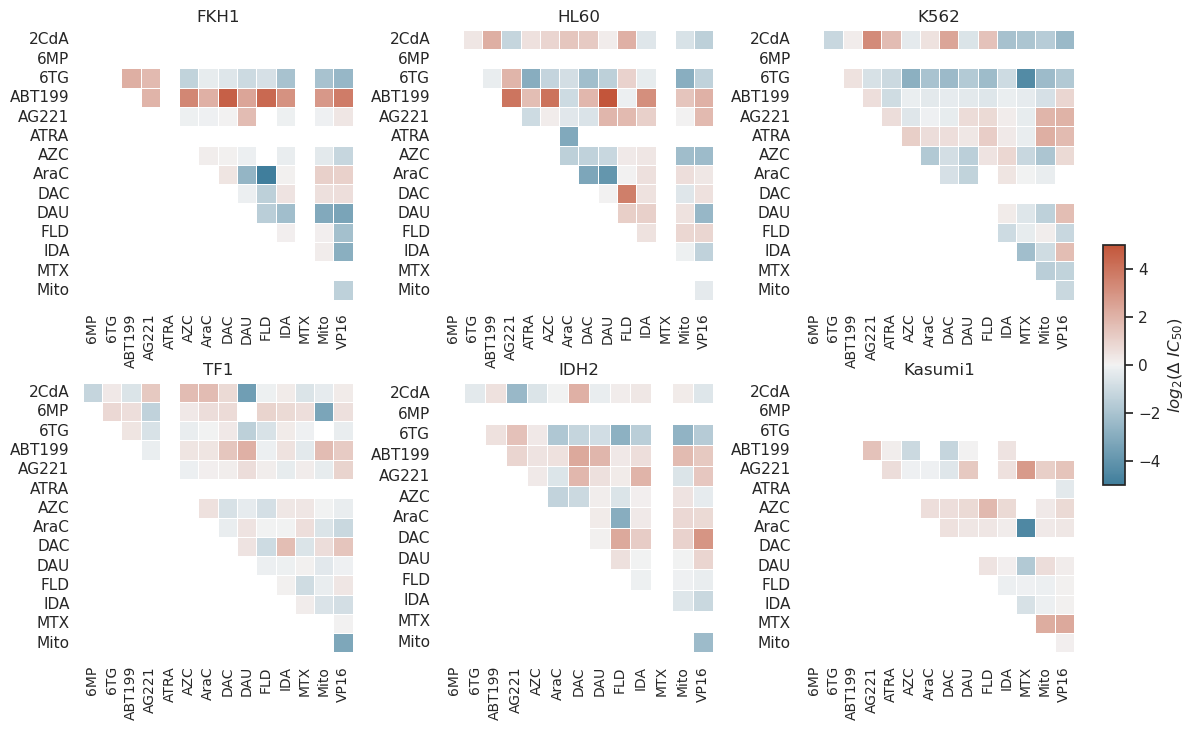

In [111]:
%matplotlib inline
# Option 1: Get max
# df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(min).to_frame().reset_index()
# Option 2: Get mean of max 2
# df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(lambda x: np.mean(np.sort(np.array(x)[0:2]))).to_frame().reset_index()
# Option 3: first classify as synergistic, antagonistic, independence, than select max
df_max = dic50_df.groupby(['cell_line', 'drugA', 'drugB'])['dIC50'].agg(classify_max).to_frame().reset_index()
df_max = df_max[ ~(df_max['drugA']==df_max['drugB']) ]

sns.set_theme(style="white")
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)
# Set up the matplotlib figure
f, axes = plt.subplots(2,3,figsize=(11, 8))

for ploti, cell_line in enumerate(raw_effect_8.keys()):
    ax = axes.flat[ploti]
    df = df_max[df_max['cell_line']==cell_line]
    dfp = df.pivot(index=['drugA'], columns=['drugB'], values=['dIC50']).droplevel(level=0,axis=1)
    # Draw the heatmap with the mask and correct aspect ratio
    hax = sns.heatmap(-dfp, ax=ax, cmap=cmap, vmax=5, center=0, vmin=-5,
                square=True, linewidths=.5, 
                xticklabels=dfp.columns, yticklabels=dfp.index,
                cbar=False, cbar_kws={"shrink": .5, "location":"right"})
    #ax.set_xticklabels(dfp.columns)
    ax.tick_params(axis='x',labelsize=10)
    ax.set_title(cell_line)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # if not(ploti in [0,3]):
    #     ax.set_yticklabels([])
    # if ploti in [0,1,2]:
    #     ax.set_xticklabels([])
cbar_ax = f.add_axes([1.01, 0.35, 0.02, 0.3])
f.colorbar(hax.get_children()[0], cax=cbar_ax, label='$log_{2}(\Delta~IC_{50}$)')
f.tight_layout()
f.subplots_adjust(hspace=0.0)
f.savefig(PROJECT_PATH / f'dump/sigmoid_synergy_estimations/bliss_v_observed_delta_ic50_heatmaps/dic50_heatmap_by_drug_pair.png',
          dpi=600, bbox_inches="tight")

In [115]:
df_max_na[
    ((df_max_na.loc[:,'drugA'].apply(lambda x: x in ['AG221','ABT199'])
    | df_max_na.loc[:,'drugB'].apply(lambda x: x in ['AG221','ABT199']))
    & (df_max_na.loc[:,'dIC50']>-1))
]

,cell_line,drugA,drugB,dIC50
56,FKH1,AG221,AZC,0.080472
57,FKH1,AG221,AraC,0.072778
58,FKH1,AG221,DAC,-0.005979
61,FKH1,AG221,IDA,0.099876
63,FKH1,AG221,Mito,0.077603
...,...,...,...,...
645,TF1,AG221,FLD,-0.119573
646,TF1,AG221,IDA,0.257196
647,TF1,AG221,MTX,-0.162296
648,TF1,AG221,Mito,0.235010


In [125]:
df_max_na = df_max[~pd.isna(df_max['dIC50'])]
print('Mean dIC50:', df_max_na.loc[:,'dIC50'].mean())
print('Std dIC50:', df_max_na.loc[:,'dIC50'].std())
print('Synergy > 1:', sum(df_max_na.loc[:,'dIC50']>=1))
print('Synergy < -1:', sum(df_max_na.loc[:,'dIC50']<=-1))
print('ABT199 or AG221 Synergistic:', sum((
                              (df_max_na.loc[:,'drugA'].apply(lambda x: x in ['AG221','ABT199'])
                              | df_max_na.loc[:,'drugB'].apply(lambda x: x in ['AG221','ABT199']))
                              & (df_max_na.loc[:,'dIC50']<=-1))))
print('6TG Antagonistic:', sum((
                              (df_max_na.loc[:,'drugA'].apply(lambda x: x in ['6TG'])
                              | df_max_na.loc[:,'drugB'].apply(lambda x: x in ['6TG']))
                              & (df_max_na.loc[:,'dIC50']>=1))))
print(df_max_na[df_max_na['dIC50']<=-1].groupby(['cell_line']).agg('count'))
df_max[~pd.isna(df_max['dIC50'])]

Mean dIC50: -0.00559461276669456
Std dIC50: 1.4711638824224542
Synergy > 1: 85
Synergy < -1: 77
ABT199 or AG221 Synergistic: 47
6TG Antagonistic: 29
           drugA  drugB  dIC50
cell_line                     
FKH1          14     14     14
HL60          21     21     21
IDH2          13     13     13
K562          12     12     12
Kasumi1        8      8      8
TF1            9      9      9


,cell_line,drugA,drugB,dIC50
30,FKH1,6TG,ABT199,-2.124312
31,FKH1,6TG,AG221,-1.762509
33,FKH1,6TG,AZC,1.343553
34,FKH1,6TG,AraC,0.248875
35,FKH1,6TG,DAC,0.516877
...,...,...,...,...
696,TF1,IDA,MTX,-0.169115
697,TF1,IDA,Mito,0.629825
698,TF1,IDA,VP16,0.849882
701,TF1,MTX,VP16,-0.016469


In [65]:
dfp = df_max.pivot(index=['drugA','drugB'],columns=['cell_line'])
# filter out drug pairs with less than two cell lines
dfp_filt = dfp[dfp.apply(lambda x: sum(~pd.isna(x))>1,axis=1)]
# filter out cell lines that does not have greater than 2 fold change in at least one cell line
dfp_filt = dfp_filt[dfp_filt.apply(lambda x: ((x>1).any() or (x<-1).any()),axis=1)]
# re-introduce flipped drug pairs for visual completeness
for i, r in dfp_filt.iterrows():
    dfp_filt.loc[(i[1],i[0]),:] = dfp_filt.loc[i,:]
dfp_filt.sort_index(inplace=True)
print(dfp_filt.shape)

(148, 6)


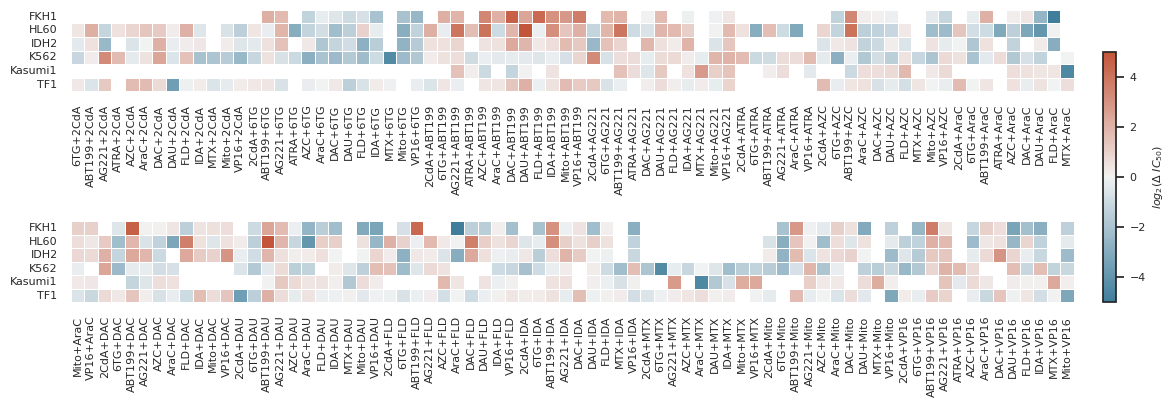

In [66]:
fig, axes = plt.subplots(2,1,figsize=(11,5))
for axi, r in enumerate([range(0,74), range(74,dfp_filt.shape[0])]):
    ax = axes[axi]
    hax = sns.heatmap(-dfp_filt.T.iloc[:,r], ax=ax, cmap=cmap, vmax=5, center=0, vmin=-5,
                    square=True, linewidths=.5, 
                    xticklabels=[f'{l[1]}+{l[0]}' for l in dfp_filt.index[r]],
                    yticklabels=dfp.columns.get_level_values(1),
                    cbar=False, cbar_kws={"shrink": .5, "location":"right"})
    ax.tick_params(labelsize=8)
    ax.set_ylabel('')
    ax.set_xlabel('')
fig.tight_layout()
cbar_ax = fig.add_axes([1.01, 0.25, 0.012, 0.5])
cbar = fig.colorbar(hax.get_children()[0], cax=cbar_ax)
cbar.set_label(label='$log_{2}(\Delta~IC_{50}$)', size=8)
cbar.ax.tick_params(labelsize=8)
fig.subplots_adjust(hspace=0)
fig.savefig(PROJECT_PATH / f'dump/sigmoid_synergy_estimations/bliss_v_observed_delta_ic50_heatmaps/dic50_heatmap_by_cell_line.png',
            dpi=600, bbox_inches='tight')

masked_array(
  data=[[1.0, 0.33683340102302944],
        [0.33683340102302944, 1.0]],
  mask=[[False, False],
        [False, False]],
  fill_value=1e+20)

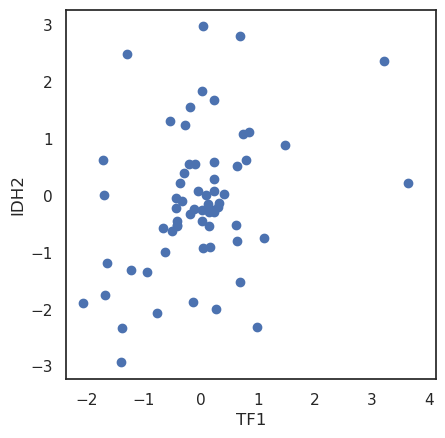

In [67]:
m = pd.merge(df_max.loc[df_max['cell_line']=='TF1',:], df_max.loc[df_max['cell_line']=='IDH2',:], on=['drugA','drugB'],how='inner')
plt.scatter(m['dIC50_x'],m['dIC50_y'])
plt.axis('square')
plt.xlabel('TF1')
plt.ylabel('IDH2')
np.ma.corrcoef(np.ma.masked_invalid(m['dIC50_x']),np.ma.masked_invalid(m['dIC50_y']))

In [81]:
significant_pairs = df_max[df_max['dIC50']<-1].sort_values(by='dIC50',ascending=True)
all_pairs = df_max.sort_values(by='dIC50',ascending=True)

all_pairs.to_csv(PROJECT_PATH / 'figures/Supplementary Table 2. All synergy scores from 8-by-8.csv',index=False)
significant_pairs.to_csv(PROJECT_PATH / 'figures/Supplementary Table 2. Significant synergy scores from 8-by-8.csv',index=False)

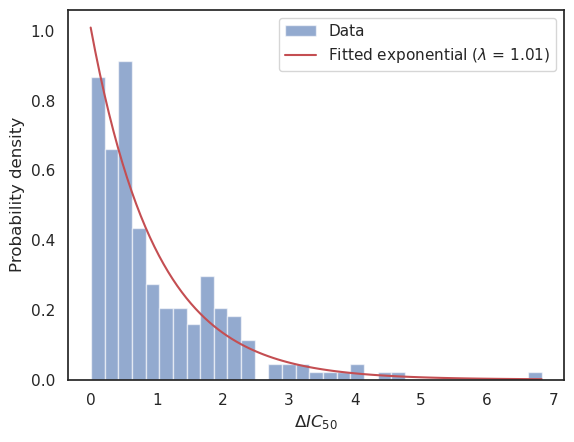

In [69]:
from scipy.optimize import curve_fit
data = -df_max.loc[df_max['dIC50']<0, 'dIC50']  # scale = 1/lambda
# Estimate the rate parameter (lambda) of the exponential distribution
lambda_estimated = 1 / np.mean(data)
# Defining exponential function to fit
def exp_func(x, lamb):
    return lamb * np.exp(-lamb * x)
# Histogram of the data
n, bins, patches = plt.hist(data, bins=33, density=True, alpha=0.6, label='Data')
# Fitting the exponential function
x = np.linspace(0, np.max(data), 100)
bin_centers = (bins[:-1] + bins[1:]) / 2
params, covariance = curve_fit(exp_func, bin_centers, n)
# Plotting the fitted distribution
y = exp_func(x, *params)
plt.plot(x, y, 'r-', label=f'Fitted exponential ($\lambda$ = {params[0]:.2f})')
# Add labels and legend
plt.xlabel('$\Delta IC_{50}$')
plt.ylabel('Probability density')
plt.legend()
# Show plot
plt.show()

1.469342006946516

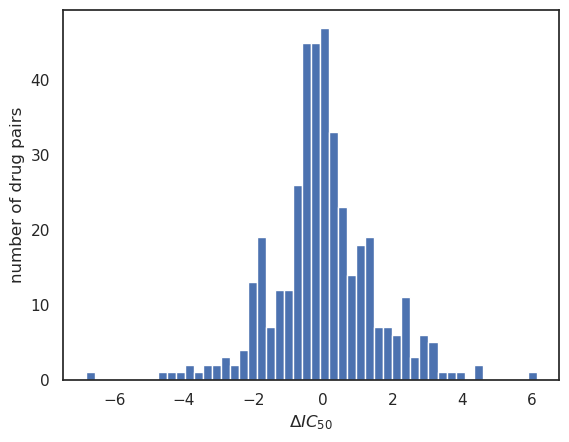

In [70]:
plt.hist(df_max['dIC50'],50);
plt.ylabel('number of drug pairs')
plt.xlabel('$\Delta IC_{50}$')
np.std(df_max['dIC50'])

In [71]:
dic50_valid = dic50_df[dic50_df['valid']=='VALID']
df = dic50_valid.groupby(['cell_line','drugA','drugB','drugB_conc'])['dIC50'].agg(lambda x: x)
df

cell_line  drugA  drugB  drugB_conc
FKH1       6TG    6TG    0.000000     -0.067187
                         2.980232     -0.652152
                         4.768372     -0.668315
                         7.629395     -0.745679
                         12.207030    -0.278836
                                         ...   
TF1        VP16   VP16   0.874257      0.532602
                         2.404207      0.887660
                         6.611570      1.188844
                         18.181820     2.040897
                         50.000000     2.708196
Name: dIC50, Length: 3167, dtype: float64

In [72]:
# merge two cell lines on the common IC50 shift estimations
dic_comp = pd.merge(left=df.loc['K562'], right=df.loc['Kasumi1'], on=['drugA', 'drugB', 'drugB_conc']).reset_index()
# remove same drug combinations
dic_comp = dic_comp[dic_comp['drugA']!=dic_comp['drugB']]
# index by pair name
dic_comp.insert(0, 'drug_pair', dic_comp['drugA'] + '_' + dic_comp['drugB'])
dic_comp.drop(['drugA', 'drugB'], axis=1, inplace=True)
dic_comp

,drug_pair,drugB_conc,dIC50_x,dIC50_y
1,ABT199_AG221,0.0,-6.759735e-02,4.703670e-02
2,ABT199_ATRA,0.0,-2.685578e-02,8.346794e-03
3,ABT199_AZC,0.0,-1.493244e-02,2.608678e-04
4,ABT199_DAC,0.0,-3.618149e-03,5.397727e-11
5,ABT199_DAU,0.0,-4.580766e-02,3.210330e-03
6,ABT199_IDA,0.0,-9.961401e-02,1.246574e-03
9,AG221_ATRA,0.0,-2.536227e-02,-4.881767e-06
10,AG221_ATRA,50.0,-6.582468e-01,-2.987850e-01
11,AG221_AZC,0.0,-4.885267e-02,-1.509310e-06
12,AG221_AraC,0.0,1.015206e-04,-3.545996e-04


In [73]:
dic_comp_min2 = dic_comp.set_index('drug_pair').loc[ dic_comp.groupby(['drug_pair'])['drugB_conc'].agg(len)>1 ].reset_index()

/home/wak/micromamba/envs/data311/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


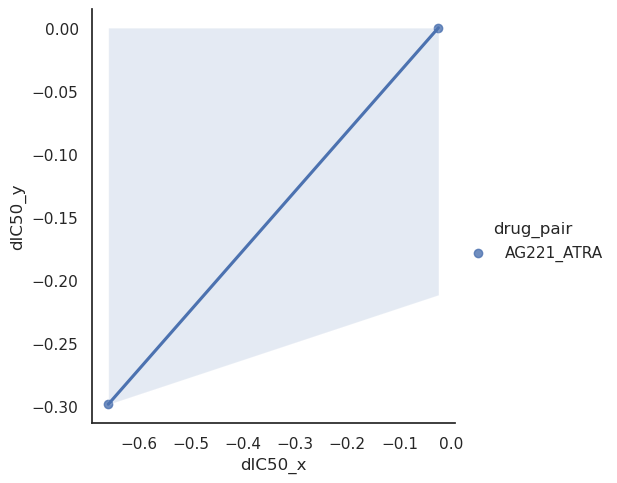

In [74]:
sns.lmplot(
    data=dic_comp_min2,
    x="dIC50_x", y="dIC50_y", hue="drug_pair",
    height=5
)

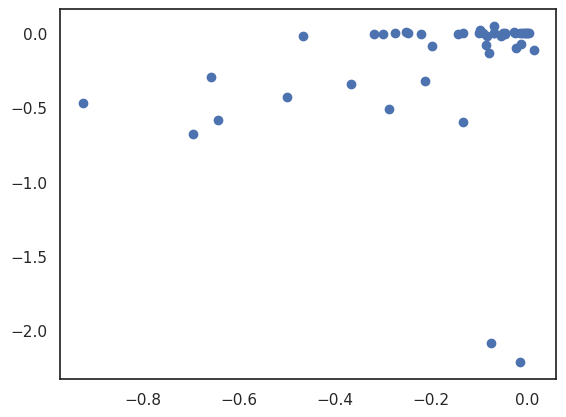

In [75]:
plt.scatter(dic_comp['dIC50_x'], dic_comp['dIC50_y'])

In [76]:
dic_max_comp = pd.merge(left=df_max[df_max['cell_line']=='FKH1'].drop('cell_line',axis=1), right=df_max[df_max['cell_line']=='HL60'].drop('cell_line',axis=1), on=['drugA', 'drugB'])
dic_max_comp['drug_pair'] = dic_max_comp['drugA'] + "_" + dic_max_comp['drugB']
dic_max_comp.drop(['drugA','drugB'],axis=1,inplace=True)
dic_max_comp = dic_max_comp[(dic_max_comp['dIC50_x']>=1) | (dic_max_comp['dIC50_y']>=1)]
dic_max_comp

,dIC50_x,dIC50_y,drug_pair
3,NaN,1.236136,2CdA_AG221
13,NaN,1.457658,2CdA_VP16
29,NaN,2.931416,6TG_ATRA
30,1.343553,1.278126,6TG_AZC
32,0.516877,2.261709,6TG_DAC
33,1.053125,1.462515,6TG_DAU
35,2.043564,0.246589,6TG_IDA
37,2.065968,2.911572,6TG_Mito
38,2.534438,1.385011,6TG_VP16
50,NaN,1.000860,AG221_ATRA


(-0.7247160720149315, 7.627515328978323, -4.015756088836218, 4.336475312157036)

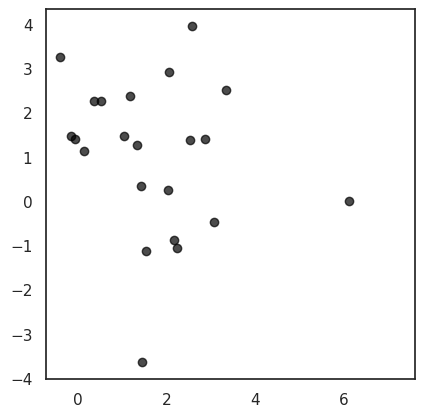

In [77]:
plt.scatter(dic_max_comp['dIC50_x'], dic_max_comp["dIC50_y"], color='black',alpha=0.7)
plt.axis('square')

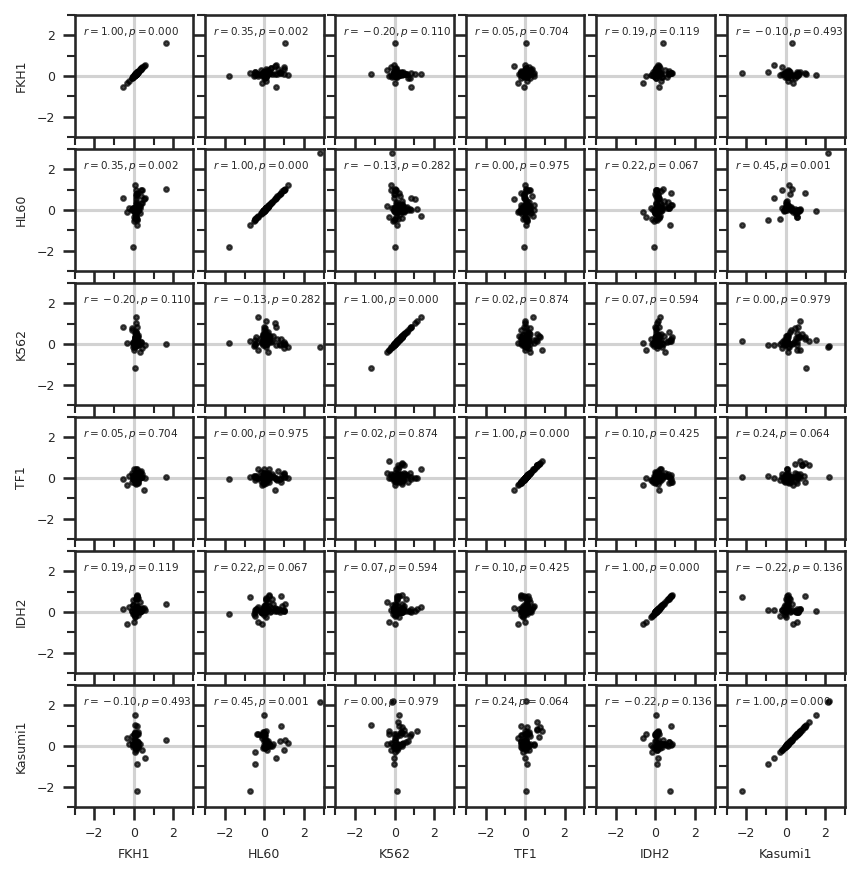

In [150]:
from scipy.stats import pearsonr
def scatter_pairwise_cell_line(cellA, cellB, ax):
    dic_max_comp = pd.merge(left=df_max[df_max['cell_line']==cellA].drop('cell_line',axis=1), right=df_max[df_max['cell_line']==cellB].drop('cell_line',axis=1), on=['drugA', 'drugB'])
    dic_max_comp['drug_pair'] = dic_max_comp['drugA'] + "_" + dic_max_comp['drugB']
    dic_max_comp.drop(['drugA','drugB'],axis=1,inplace=True)
    # show only drug pairs that have greater than 2 fold dIC50
    #dic_max_comp = dic_max_comp[(dic_max_comp['dIC50_x']>=1) | (dic_max_comp['dIC50_y']>=1)]
    ax.plot([-8,8],[0,0],color='gray',alpha=0.35,zorder=1)
    ax.plot([0,0],[-8,8],color='gray',alpha=0.35,zorder=1)
    ax.scatter(dic_max_comp['dIC50_y'], dic_max_comp["dIC50_x"], s=5, color='black',alpha=0.7,zorder=2)
    ax.set_xlim([-3,3])
    ax.set_ylim([-3,3])
    # ax.set_yticks(list(range(9)))
    # ax.set_xticks(list(range(9)))
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    ax.yaxis.set_ticks_position('left')
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
    ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
    ax.tick_params(labelsize=6)
    # get the correlation between all valid drug pair estimations
    dic_max_comp = dic_max_comp.loc[~pd.isna(dic_max_comp['dIC50_x']) & ~pd.isna(dic_max_comp['dIC50_y']),:]
    r, p = pearsonr(dic_max_comp['dIC50_x'],dic_max_comp['dIC50_y'])
    ax.text(-2.6, 2, f'$r={r:.2f},p={p:.3f}$',fontsize=5)
    #ax.text(-7.2, -7, f'$p={p:.2f}$',fontsize=6)
    #ax.axis('square')

fig, axes = plt.subplots(6,6, figsize=(6,6), dpi=150)
for ploti, cell_line_i in enumerate(raw_effect_8.keys()):
    for plotj, cell_line_j in enumerate(raw_effect_8.keys()):
        ax = axes[ploti, plotj]
        scatter_pairwise_cell_line(cell_line_i, cell_line_j, ax)
        if plotj!=0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(cell_line_i,fontsize=6)
        if ploti!=5:
            ax.set_xticklabels([])
        else:
            ax.set_xlabel(cell_line_j,fontsize=6)
fig.tight_layout()
fig.subplots_adjust(hspace=0.1, wspace=0.1)
# fig.savefig(PROJECT_PATH / f'dump/sigmoid_synergy_estimations/dic50_correlations_btw_cell_lines.png',
#             dpi=600, bbox_inches='tight')